# Donut Regression Discontinuity

This notebook demonstrates **{term}`donut regression discontinuity`** (donut RDD), a robustness technique for regression discontinuity designs. Donut RDD excludes observations within a specified distance from the treatment threshold, addressing concerns about {term}`manipulation<Manipulation>`, sorting, or {term}`heaping<Heaping>` of the running variable near the cutoff.


In [1]:
import causalpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## What is Donut RDD?

A standard **{term}`sharp RDD<Sharp regression discontinuity design>`** estimates the discontinuity at the threshold $c$ by fitting a model locally around $c$ (often via a bandwidth restriction). In CausalPy, this is supported via the `bandwidth` kwarg, which fits only on data where $c - h \le x \le c + h$.

A **donut RDD** adds an **inner exclusion region** around the threshold and estimates the discontinuity using data *near* but *not too near* $c$.

### How observations are selected

Donut RDD keeps observations that satisfy **both** conditions:
1. **Far enough from threshold**: distance from threshold $\ge d$ (the donut hole)
2. **Close enough to threshold**: distance from threshold $\le h$ (the bandwidth)

In other words, we keep observation $i$ if:

$$d \le |x_i - c| \le h$$

where $|x_i - c|$ is the absolute distance between observation $i$'s running variable value and the threshold.

**Visual intuition**: Think of a donut (or ring). The threshold is at the center. We exclude:
- The "hole" in the middle (observations too close to the threshold)
- Everything outside the donut (observations too far from the threshold)

We only fit our model using observations in the "ring" of the donut.

**Parameters**:
- $c$ = treatment threshold (center of the donut)
- $d$ = donut hole size (inner radius - observations closer than this are excluded)
- $h$ = bandwidth (outer radius - observations farther than this are excluded)

See {cite:t}`noack2024donut` for formal discussion of donut RDD properties and {cite:t}`lee2010regression` for a comprehensive overview of RDD methods.


## Why Use Donut RDD?

Donut RDD is typically used as a **robustness strategy** when observations closest to the cutoff are suspected to be problematic:

### Manipulation / Sorting

Agents may strategically influence their running variable to fall just above or below the threshold. For example:
- Students scoring just above a passing grade
- Applicants with income just below an eligibility threshold

The McCrary density test {cite:t}`mccrary2008manipulation` is a classic diagnostic for detecting such manipulation by testing for discontinuities in the density of the running variable.

### Heaping / Rounding

Running variable values may cluster at round numbers due to rounding or measurement conventions. This heaping can:
- Create mass points correlated with outcomes or covariates
- Bias local fits near the threshold

See {cite:t}`barreca2016heaping` for analysis of heaping-induced bias in RDD.


## Generate Synthetic Data with Manipulation and Heaping

To demonstrate when donut RDD is most useful, we'll generate synthetic data that exhibits two common problems:

1. **Heaping**: Some running variable values are rounded to the nearest 0.1
2. **Manipulation**: Some observations just below the threshold "sort" to just above it

Crucially, manipulators have systematically different outcomes - they are high-motivation individuals who would have performed better anyway. This creates selection bias that inflates the naive RDD estimate.


In [3]:
# Data generation parameters
THRESHOLD = 0.5
TRUE_EFFECT = 0.5  # The true causal effect we want to recover
N_OBS = 1000


def generate_donut_rdd_data(
    n=500,
    threshold=0.5,
    true_effect=0.5,
    heaping_intensity=0.3,
    manipulation_prob=0.7,  # Probability that an obs in manipulation zone sorts above
    manipulation_width=0.08,  # Width of zone below threshold where manipulation occurs
    manipulation_bias=0.6,  # Extra outcome for manipulators (selection bias)
    seed=42,
):
    """
    Generate RDD data with heaping and manipulation near threshold.

    Parameters
    ----------
    n : int
        Number of observations
    threshold : float
        Treatment threshold
    true_effect : float
        The true causal effect of treatment
    heaping_intensity : float
        Fraction of observations that get rounded (0-1)
    manipulation_prob : float
        Probability that an observation in the manipulation zone sorts above threshold
    manipulation_width : float
        Width of zone below threshold where manipulation can occur
    manipulation_bias : float
        Additional outcome boost for manipulators (creates selection bias)
    seed : int
        Random seed for reproducibility
    """
    np.random.seed(seed)

    # Base running variable (uniform)
    x = np.random.uniform(0, 1, n)

    # Add heaping: round some observations to nearest 0.1
    heaping_mask = np.random.random(n) < heaping_intensity
    x[heaping_mask] = np.round(x[heaping_mask], 1)

    # Add manipulation: observations just below threshold may "sort" to just above
    manipulation_zone = (x >= threshold - manipulation_width) & (x < threshold)
    manipulators = manipulation_zone & (np.random.random(n) < manipulation_prob)
    n_manipulators = manipulators.sum()
    # Manipulators end up just above threshold (concentrated near it)
    x[manipulators] = threshold + np.abs(np.random.normal(0.01, 0.012, n_manipulators))

    # Treatment assignment (sharp RDD)
    treated = (x >= threshold).astype(int)

    # Outcome: linear relationship + true treatment effect + noise
    y = 0.5 + 1.5 * x + true_effect * treated + np.random.normal(0, 0.25, n)

    # Manipulators have systematically higher outcomes (selection bias)
    # They are high-motivation individuals who would have done better anyway
    manipulator_indices = np.where(manipulators)[0]
    y[manipulator_indices] += manipulation_bias

    return pd.DataFrame({"x": x, "treated": treated, "y": y}), n_manipulators


# Generate the data with strong manipulation to demonstrate donut RDD
df, n_manipulators = generate_donut_rdd_data(
    n=N_OBS,
    threshold=THRESHOLD,
    true_effect=TRUE_EFFECT,
    manipulation_prob=0.9,  # 90% of people in manipulation zone will sort above
    manipulation_width=0.12,  # Wider zone [0.38, 0.5] where manipulation occurs
    manipulation_bias=0.8,  # Strong outcome boost for manipulators
    seed=seed,
)

print(f"Generated {len(df)} observations")
print(f"True causal effect: {TRUE_EFFECT}")
print(f"Number of manipulators: {n_manipulators}")
df.head()

Generated 1000 observations
True causal effect: 0.5
Number of manipulators: 76


,x,treated,y
0,0.522719,1,2.727093
1,0.950714,1,2.410524
2,0.731994,1,2.379079
3,0.598658,1,1.814468
4,0.156019,0,0.875179


### Diagnostic: Running Variable Density

Before applying donut RDD, it's useful to examine the distribution of the running variable near the threshold. Signs of problems include:
- **Bunching just above the threshold**: indicates manipulation/sorting
- **Spikes at round numbers**: indicates heaping/rounding

Let's visualize our synthetic data to see these patterns:


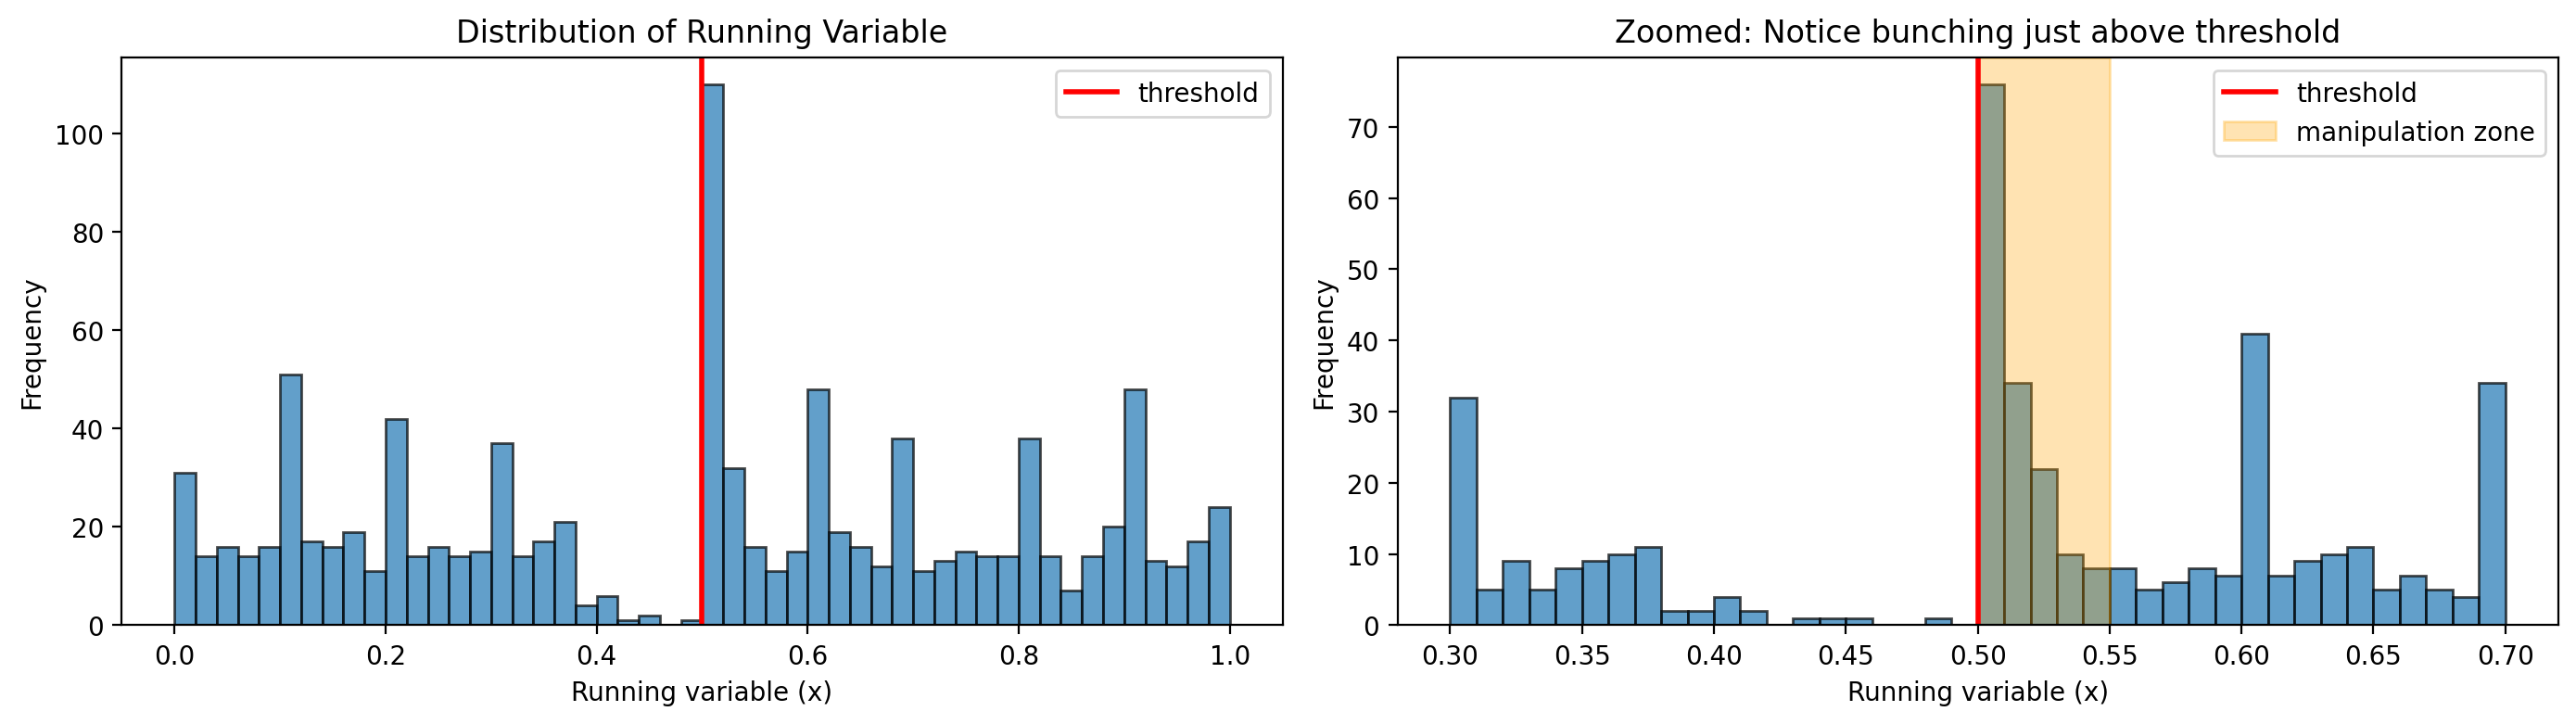

Observations just below threshold (0.45-0.50): 2
Observations just above threshold (0.50-0.55): 150
Ratio (above/below): 75.00

This asymmetry suggests manipulation - individuals sorting from below to above the threshold.


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left panel: Full distribution
ax = axes[0]
ax.hist(df["x"], bins=50, edgecolor="black", alpha=0.7)
ax.axvline(x=THRESHOLD, color="r", linestyle="-", linewidth=2, label="threshold")
ax.set_xlabel("Running variable (x)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Running Variable")
ax.legend()

# Right panel: Zoomed in near threshold to show bunching
ax = axes[1]
near_threshold = df[(df["x"] >= 0.3) & (df["x"] <= 0.7)]
ax.hist(near_threshold["x"], bins=40, edgecolor="black", alpha=0.7)
ax.axvline(x=THRESHOLD, color="r", linestyle="-", linewidth=2, label="threshold")
ax.axvspan(
    THRESHOLD, THRESHOLD + 0.05, alpha=0.3, color="orange", label="manipulation zone"
)
ax.set_xlabel("Running variable (x)")
ax.set_ylabel("Frequency")
ax.set_title("Zoomed: Notice bunching just above threshold")
ax.legend()

plt.tight_layout()
plt.show()

# Count observations in key regions
below = (df["x"] >= THRESHOLD - 0.05) & (df["x"] < THRESHOLD)
above = (df["x"] >= THRESHOLD) & (df["x"] < THRESHOLD + 0.05)
print(f"Observations just below threshold (0.45-0.50): {below.sum()}")
print(f"Observations just above threshold (0.50-0.55): {above.sum()}")
print(f"Ratio (above/below): {above.sum() / max(below.sum(), 1):.2f}")
print(
    "\nThis asymmetry suggests manipulation - individuals sorting from below to above the threshold."
)

The density plot reveals two problems in our synthetic data:

1. **Bunching just above threshold**: The zoomed plot shows more observations just above 0.5 than just below - evidence of manipulation/sorting
2. **Heaping at round numbers**: Notice spikes at 0.3, 0.4, 0.5, 0.6, 0.7 - evidence of rounding

These are exactly the situations where donut RDD can help by excluding the problematic observations near the threshold.


## Baseline: Standard RDD (Biased by Manipulation)

First, let's fit a standard RDD without any donut hole exclusion. We use a bandwidth to focus on observations near the threshold - this is where manipulation matters most, and where the bias will be visible.

Since we generated the data, we know the **true causal effect is 0.5**. Let's see if the standard RDD recovers this value, or if the manipulation biases our estimate.


In [5]:
# Define bandwidth for local estimation (used throughout this notebook)
BANDWIDTH = 0.25

result_baseline = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=THRESHOLD,
    bandwidth=BANDWIDTH,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


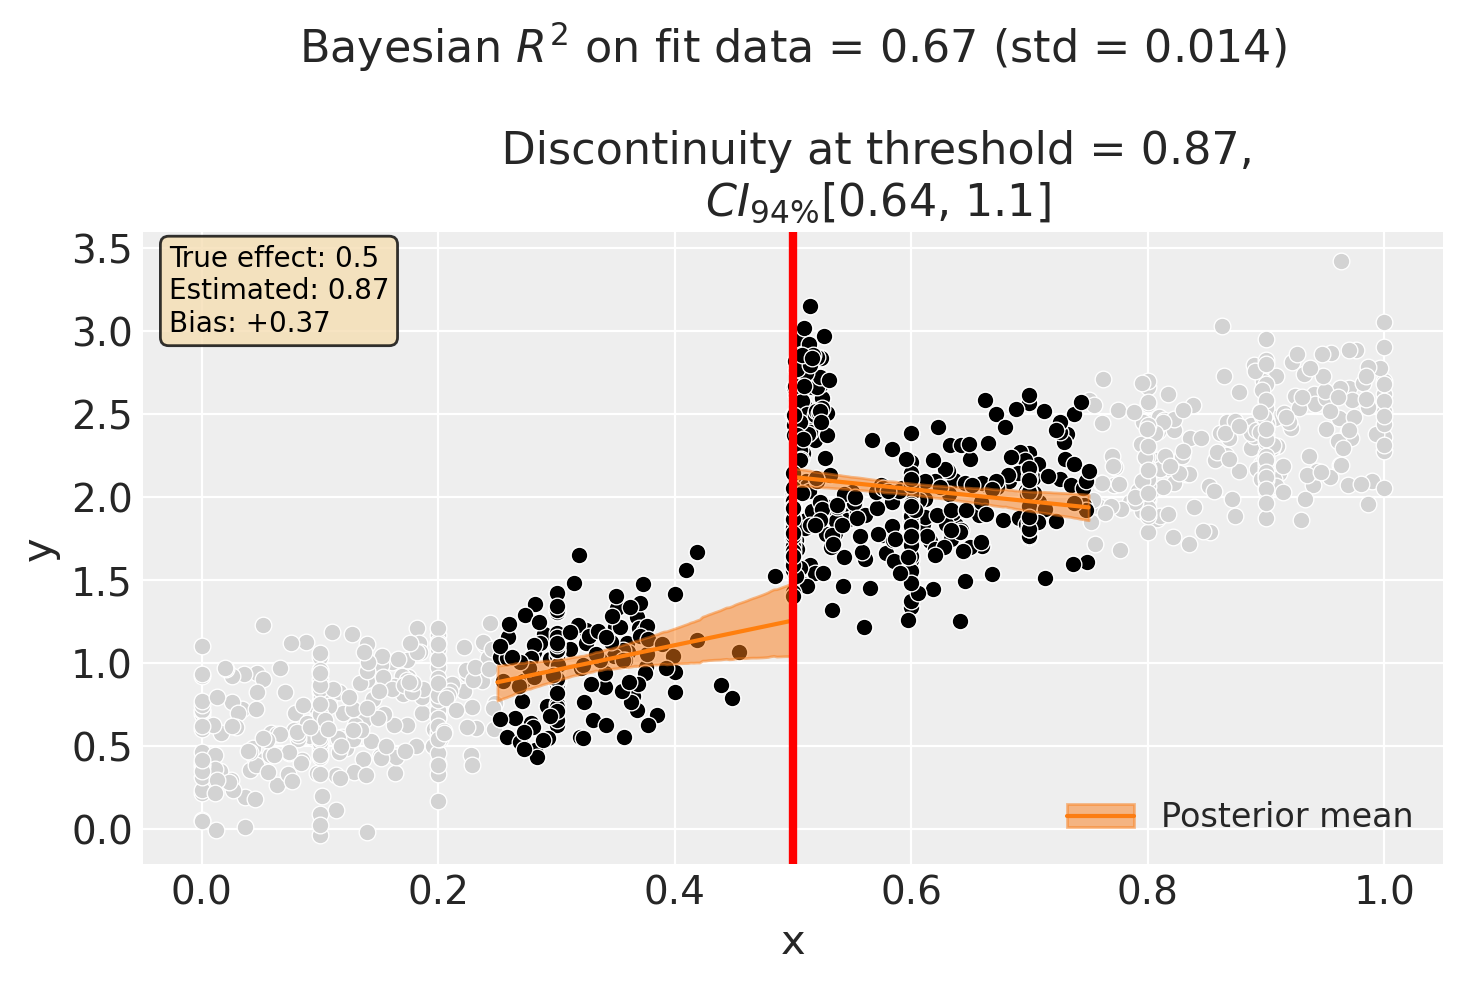

In [6]:
fig, ax = result_baseline.plot()

# Add true effect annotation (for synthetic data parameter recovery)
baseline_estimate = float(result_baseline.discontinuity_at_threshold.mean())
ax.annotate(
    f"True effect: {TRUE_EFFECT}\nEstimated: {baseline_estimate:.2f}\nBias: {baseline_estimate - TRUE_EFFECT:+.2f}",
    xy=(0.02, 0.98),
    xycoords="axes fraction",
    verticalalignment="top",
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
)
plt.show()

In [7]:
result_baseline.summary()

Regression Discontinuity experiment
Formula: y ~ 1 + x + treated + x:treated
Running variable: x
Threshold on running variable: 0.5
Bandwidth: 0.25
Donut hole: 0.0
Observations used for fit: 488

Results:
Discontinuity at threshold = 0.87$CI_{94\%}$[0.64, 1.1]


Model coefficients:
    Intercept          0.51, 94% HDI [0.11, 0.9]
    treated[T.True]    2, 94% HDI [1.5, 2.5]
    x                  1.5, 94% HDI [0.3, 2.7]
    x:treated[T.True]  -2.2, 94% HDI [-3.5, -0.91]
    y_hat_sigma        0.34, 94% HDI [0.32, 0.36]


## Using the `donut_hole` Parameter to Remove Bias

The standard RDD estimate is biased upward because manipulators (who have systematically higher outcomes) are included in the fit. By using `donut_hole=0.04`, we exclude observations within 0.04 units of the threshold - precisely where the manipulators are bunched.

Let's see if this recovers the true effect:


In [8]:
result_donut = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=THRESHOLD,
    bandwidth=BANDWIDTH,
    donut_hole=0.04,  # Exclude observations within 0.04 of threshold
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


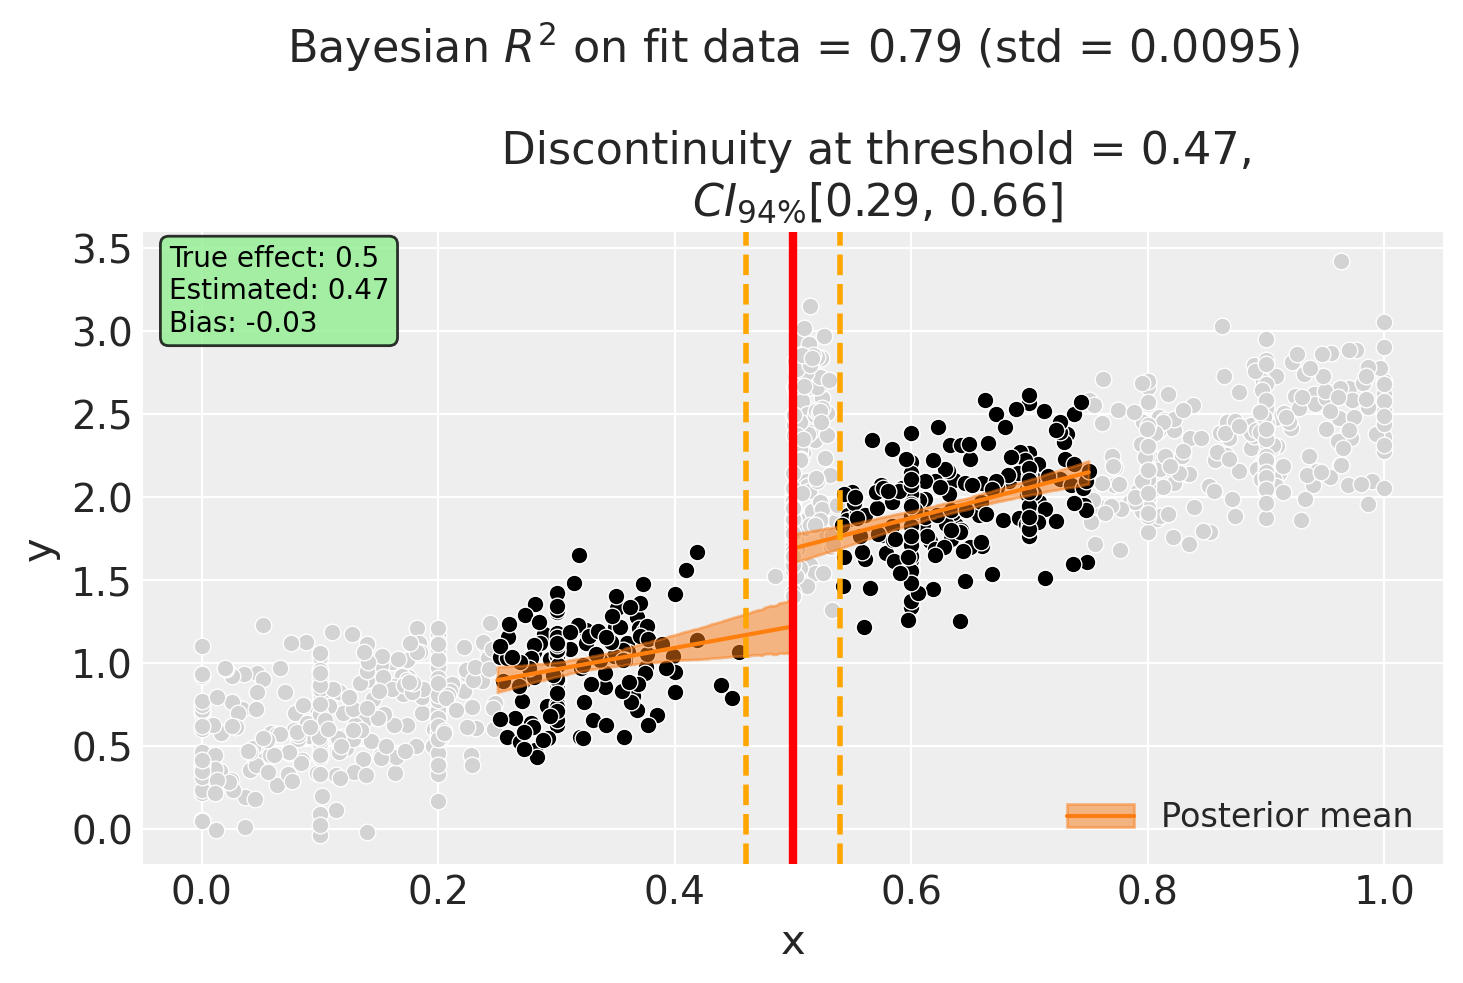

In [9]:
fig, ax = result_donut.plot()

# Add true effect annotation (for synthetic data parameter recovery)
donut_estimate = float(result_donut.discontinuity_at_threshold.mean())
ax.annotate(
    f"True effect: {TRUE_EFFECT}\nEstimated: {donut_estimate:.2f}\nBias: {donut_estimate - TRUE_EFFECT:+.2f}",
    xy=(0.02, 0.98),
    xycoords="axes fraction",
    verticalalignment="top",
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.8),
)
plt.show()

Notice in the plot:
- **Light gray points**: Observations excluded from model fitting (within the donut hole) - this includes the manipulators!
- **Black points**: Observations used for model fitting
- **Orange dashed lines**: Donut hole boundaries at threshold ± donut_hole

The donut RDD estimate is now much closer to the true effect of 0.5, demonstrating how excluding problematic observations can reduce bias.


In [10]:
result_donut.summary()

Regression Discontinuity experiment
Formula: y ~ 1 + x + treated + x:treated
Running variable: x
Threshold on running variable: 0.5
Bandwidth: 0.25
Donut hole: 0.04
Observations used for fit: 345

Results:
Discontinuity at threshold = 0.47$CI_{94\%}$[0.29, 0.66]


Model coefficients:
    Intercept          0.58, 94% HDI [0.29, 0.87]
    treated[T.True]    0.2, 94% HDI [-0.29, 0.67]
    x                  1.3, 94% HDI [0.41, 2.2]
    x:treated[T.True]  0.54, 94% HDI [-0.53, 1.6]
    y_hat_sigma        0.25, 94% HDI [0.23, 0.27]


## Alternative: Larger Bandwidth with Donut

We can also explore using a larger bandwidth with the donut. This includes more data (reducing variance) while still excluding the problematic observations near the threshold.


In [11]:
result_combined = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=THRESHOLD,
    bandwidth=0.3,
    donut_hole=0.05,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


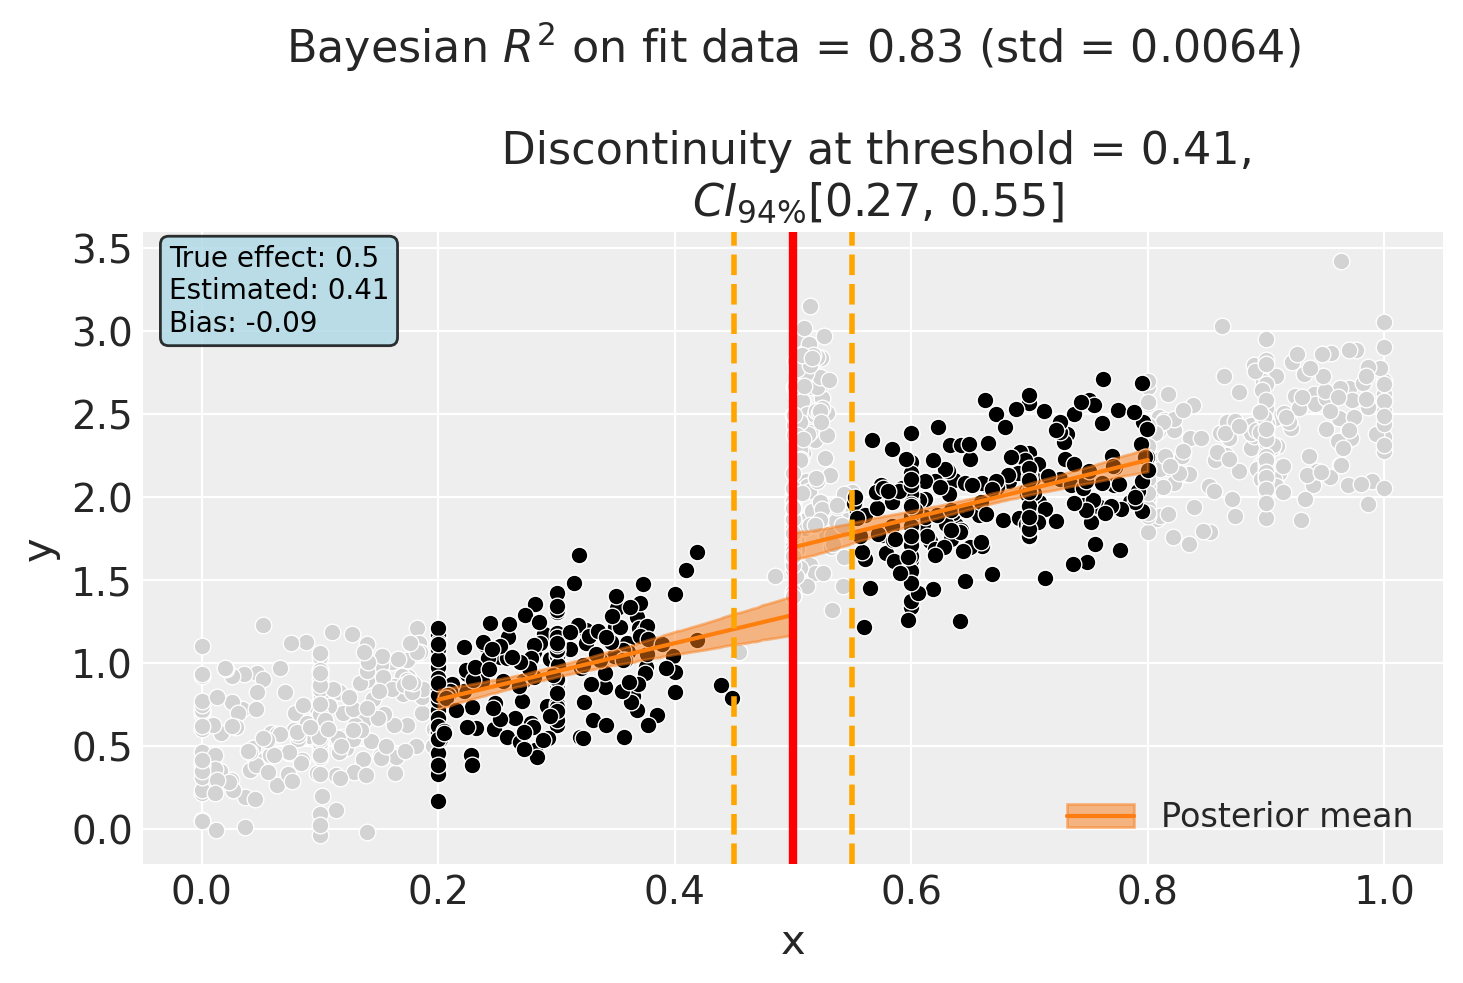

In [12]:
fig, ax = result_combined.plot()

# Add true effect annotation
combined_estimate = float(result_combined.discontinuity_at_threshold.mean())
ax.annotate(
    f"True effect: {TRUE_EFFECT}\nEstimated: {combined_estimate:.2f}\nBias: {combined_estimate - TRUE_EFFECT:+.2f}",
    xy=(0.02, 0.98),
    xycoords="axes fraction",
    verticalalignment="top",
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.8),
)
plt.show()

In [13]:
result_combined.summary()

Regression Discontinuity experiment
Formula: y ~ 1 + x + treated + x:treated
Running variable: x
Threshold on running variable: 0.5
Bandwidth: 0.3
Donut hole: 0.05
Observations used for fit: 436

Results:
Discontinuity at threshold = 0.41$CI_{94\%}$[0.27, 0.55]


Model coefficients:
    Intercept          0.44, 94% HDI [0.28, 0.6]
    treated[T.True]    0.38, 94% HDI [0.045, 0.71]
    x                  1.7, 94% HDI [1.2, 2.3]
    x:treated[T.True]  0.055, 94% HDI [-0.63, 0.75]
    y_hat_sigma        0.25, 94% HDI [0.23, 0.27]


## Sensitivity Analysis: Varying the Donut Hole Size

A key use of donut RDD is as a robustness check. By varying the `donut_hole` parameter, we can assess how sensitive the estimated discontinuity is to excluding observations near the threshold.

**Important**: We use a bandwidth here to focus on observations near the threshold. This makes the manipulators a larger fraction of the local sample, so their bias effect becomes visible. With infinite bandwidth, the manipulators would be diluted among all observations.


In [14]:
# Use the same bandwidth as earlier - this focuses on local data
# making manipulators a larger fraction of the sample
donut_sizes = np.linspace(0, 0.1, 11)
results = []

for d in donut_sizes:
    result = cp.RegressionDiscontinuity(
        df,
        formula="y ~ 1 + x + treated + x:treated",
        model=cp.pymc_models.LinearRegression(
            sample_kwargs={"random_seed": seed, "progressbar": False}
        ),
        treatment_threshold=THRESHOLD,
        donut_hole=d,
        bandwidth=BANDWIDTH,
    )

    # Extract the mean discontinuity estimate
    mean_effect = float(result.discontinuity_at_threshold.mean())
    hdi_low = float(result.discontinuity_at_threshold.quantile(0.03))
    hdi_high = float(result.discontinuity_at_threshold.quantile(0.97))
    n_fit = len(result.fit_data)
    bias = mean_effect - TRUE_EFFECT

    results.append(
        {
            "donut_hole": d,
            "mean_effect": mean_effect,
            "hdi_low": hdi_low,
            "hdi_high": hdi_high,
            "n_fit": n_fit,
            "bias": bias,
        }
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Initializing NUTS usin

In [15]:
sensitivity_df = pd.DataFrame(results)
sensitivity_df

,donut_hole,mean_effect,hdi_low,hdi_high,n_fit,bias
0,0.00,0.865258,0.639026,1.090866,488,0.365258
1,0.01,0.836184,0.638581,1.042738,412,0.336184
2,0.02,0.713336,0.507412,0.913917,377,0.213336
3,0.03,0.505974,0.325246,0.688565,355,0.005974
4,0.04,0.472827,0.288240,0.660284,345,-0.027173
5,0.05,0.450495,0.255123,0.638132,336,-0.049505
6,0.06,0.421619,0.219993,0.623332,327,-0.078381
7,0.07,0.380284,0.163089,0.592247,321,-0.119716
8,0.08,0.364301,0.154032,0.582364,315,-0.135699
9,0.09,0.387938,0.160533,0.625009,305,-0.112062


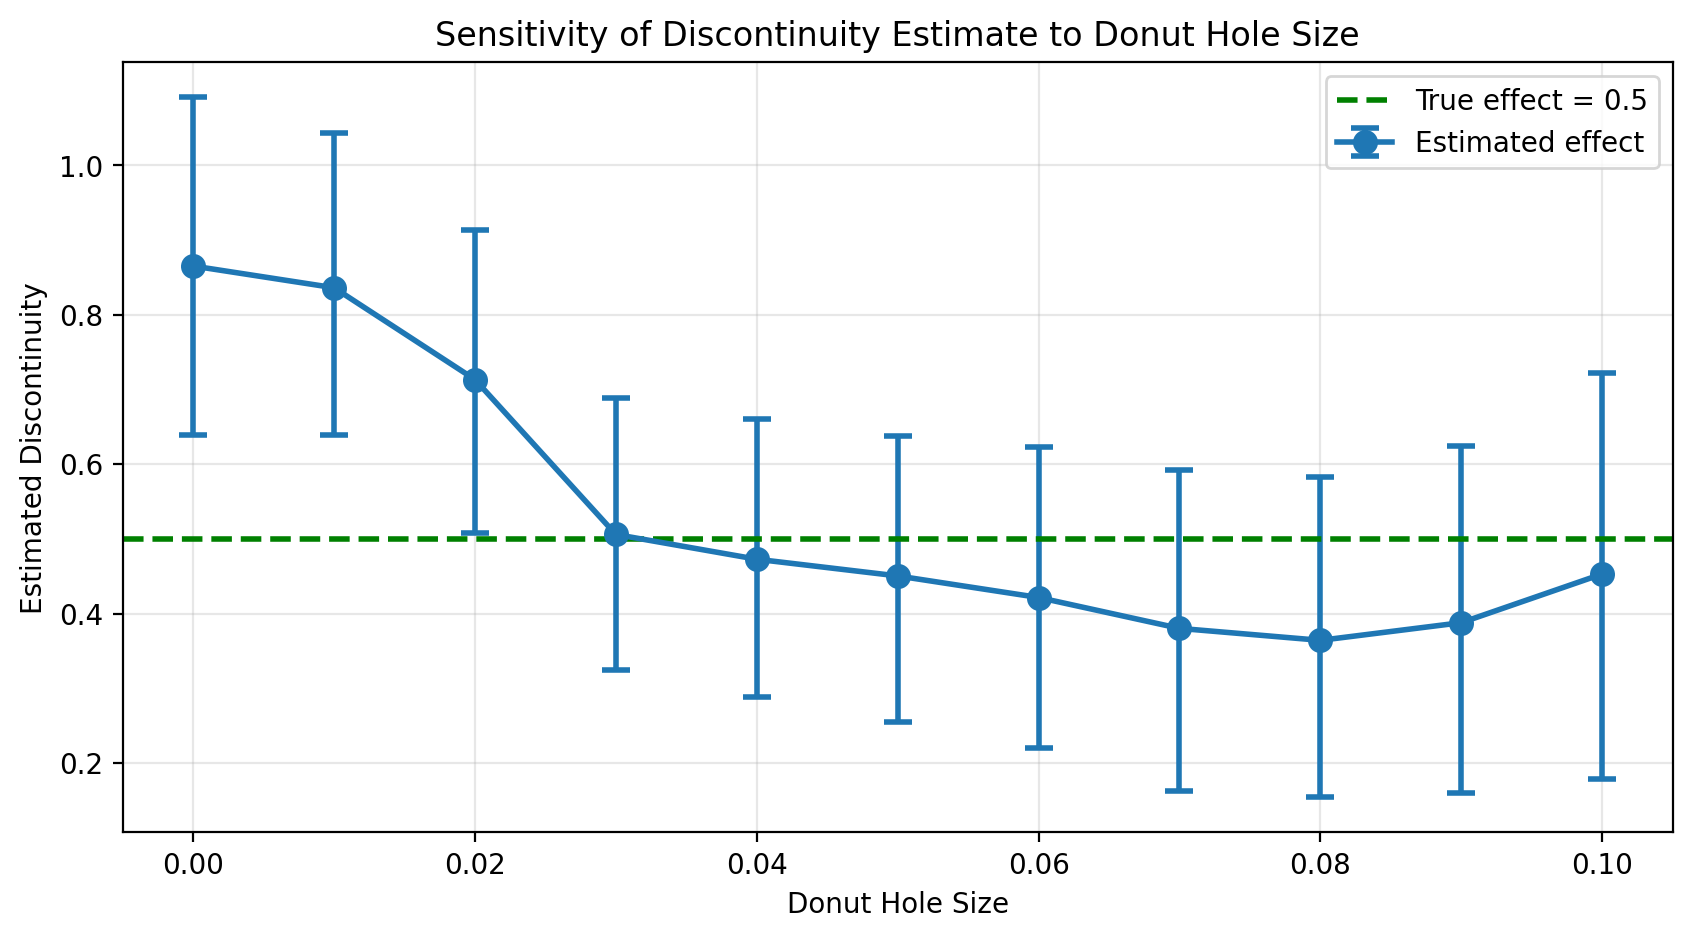

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.errorbar(
    sensitivity_df["donut_hole"],
    sensitivity_df["mean_effect"],
    yerr=[
        sensitivity_df["mean_effect"] - sensitivity_df["hdi_low"],
        sensitivity_df["hdi_high"] - sensitivity_df["mean_effect"],
    ],
    marker="o",
    capsize=5,
    capthick=2,
    linewidth=2,
    markersize=8,
    label="Estimated effect",
)

# Add true effect line
ax.axhline(
    y=TRUE_EFFECT,
    color="green",
    linestyle="--",
    linewidth=2,
    label=f"True effect = {TRUE_EFFECT}",
)

ax.set_xlabel("Donut Hole Size")
ax.set_ylabel("Estimated Discontinuity")
ax.set_title("Sensitivity of Discontinuity Estimate to Donut Hole Size")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

The sensitivity plot reveals the story:

1. **With no donut hole (d=0)**, the estimate is biased upward due to manipulation
2. **As the donut grows**, the estimate moves toward the true effect (green line)
3. **Stability at larger donut sizes** suggests we've successfully excluded the problematic observations

This is the hallmark of a successful donut RDD analysis: the estimate converges toward a stable value as we exclude more observations near the threshold, and that stable value is closer to the truth.


## Summary: Comparing Estimates to Ground Truth

Since we used synthetic data with a known true effect, we can directly compare how well each approach recovers the true causal effect:


In [17]:
# Create comparison table
comparison_data = {
    "Method": [
        "True Effect",
        "Standard RDD (no donut)",
        "Donut RDD (d=0.05)",
        "Donut RDD + Bandwidth (d=0.05, h=0.3)",
    ],
    "Estimate": [
        TRUE_EFFECT,
        baseline_estimate,
        donut_estimate,
        combined_estimate,
    ],
    "Bias": [
        0.0,
        baseline_estimate - TRUE_EFFECT,
        donut_estimate - TRUE_EFFECT,
        combined_estimate - TRUE_EFFECT,
    ],
    "Observations Used": [
        "-",
        len(result_baseline.fit_data),
        len(result_donut.fit_data),
        len(result_combined.fit_data),
    ],
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df["Estimate"] = comparison_df["Estimate"].apply(lambda x: f"{x:.3f}")
comparison_df["Bias"] = comparison_df["Bias"].apply(lambda x: f"{x:+.3f}")
comparison_df.style.set_caption("Parameter Recovery: Standard RDD vs Donut RDD")

,Method,Estimate,Bias,Observations Used
0,True Effect,0.500,+0.000,-
1,Standard RDD (no donut),0.865,+0.365,488
2,Donut RDD (d=0.05),0.473,-0.027,345
3,"Donut RDD + Bandwidth (d=0.05, h=0.3)",0.410,-0.090,436


**Key findings:**
- The **standard RDD** overestimates the effect due to manipulation - manipulators have higher outcomes and are incorrectly attributed to the treatment
- **Donut RDD** substantially reduces bias by excluding the manipulated observations
- The **combined approach** (donut + bandwidth) provides the best estimate in this case

:::{note}
In real-world applications, you won't know the true effect. The value of this synthetic exercise is to demonstrate *why* donut RDD works and build intuition for interpreting sensitivity analyses. When estimates stabilize as the donut grows, it suggests you've excluded the problematic observations.
:::


## Interpretation Cautions

While donut RDD is a useful robustness technique, it comes with important caveats:

1. **Increased variance**: Removing observations closest to the threshold reduces sample size and increases estimation uncertainty.

2. **Reliance on functional form**: With less data near the threshold, the estimate relies more heavily on the assumed functional form (e.g., linear, polynomial).

3. **Not a fix for all problems**: If the entire dataset is affected by manipulation or measurement issues, donut RDD alone may not resolve them.

4. **Complementary diagnostics**: Donut RDD should be used alongside other diagnostics like the McCrary density test, covariate balance checks, and bandwidth sensitivity analysis.

For a thorough treatment of these issues, see {cite:t}`noack2024donut`.


## References

:::{bibliography}
:filter: docname in docnames
:::
